## Using PINNs to model a damped harmonic oscillator

The most basic simple harmonic oscillator follows a second order differential equation:
$$\frac{d^2 x}{dt^2} = -\frac{k}{m}x$$
Describing the angular frequency by $\omega$, the equation and its solution are
$$\ddot{x} = -\omega^2 x$$
$$x = A\sin(\omega t + \delta)$$
where $A$ is the amplitude and $\delta$ is a phase.

If we introduce a damping (friction) force $F_f = -bv$ where $b > 0$ and $v$ is velocity, the equation of motion becomes

$$m\ddot{x} + b\dot{x} + kx = 0$$

First let us see how this is solved analytically, and then how we can model it using a physics-informed neural network.



### Analytical Solution
Let us divide by mass to get new constants, $\gamma = b/2m$ and $\omega_0^2 = k/m$. The new equation is
$$\ddot{x} + 2\gamma\dot{x} + \omega_0^2 x = 0$$

This can be solved by guessing an exponential solution, $x = Ae^{\alpha t}$. Substituting for $x$,
$$Ae^{\alpha t} (\alpha^2 + 2\gamma\alpha + \omega_0^2) = 0$$
Since $x$ is non-zero, the second term must be zero, and so
$$\alpha^2 + 2\gamma\alpha + \omega_0^2 = 0$$
Now we can easily solve for $\alpha$ to get
$$\alpha = \frac{-2\gamma \pm \sqrt{4\gamma^2 - 4\omega_0^2}}{2} = -\gamma \pm \sqrt{\gamma^2 - \omega_0^2}$$

We consider the underdamped case, where $\omega_0^2 > \gamma^2$, so that $\alpha$ becomes imaginary. To write the solution for $x$, remember that $x = Ae^{\alpha t}$, but since there are two roots for $\alpha$, we write the solution as a superposition, finally obtaining
$$x = A_1 e^{\left(-\gamma + \sqrt{\gamma^2 - \omega_0^2}\right)t} + A_2 e^{\left(-\gamma - \sqrt{\gamma^2 - \omega_0^2}\right)t}$$

Defining $\omega = \sqrt{\gamma^2 - \omega_0^2}$, we get,
$$ x = e^{-\gamma t}\left(A_1e^{\omega t} + A_2e^{-\omega t}\right)$$

Since $\omega$ is imaginary, we can use Euler's identity to get
$$x = e^{-\gamma t}\left[(A_1 + A_2)\cos(\omega t) + i(A_1 - A_2)\sin(\omega t) \right]$$

Now if we define $A = 4A_1A_2$ we can obtain 
$$A_1 + A_2 = A\cos \delta, \quad i(A_1 - A_2) = A\sin \delta$$
This gives us a more convenient way to write the solution,
$$\boxed{x = Ae^{-\gamma t}\cos(\omega t - \delta)}$$
where $A$ and $\delta$ are determined by initial/boundary conditions.


### Modelling the oscillator using a PINN

One of the biggest advantages of using PINNs is the ability to use our knowledge of physics to overcome a lack of training data. While most problems involve the differential equation (of motion in our case) supplementing some limited dataset, to solve a simple problem like this, we don't need any real-world training data at all!

Instead, we define our training data based on boundary conditions (BCs). Here, we can specify two conditions on our solution without assuming its analytic form - a) it will start from some given position, $x_0$, and b) it will start from rest (0 velocity). More explicitly,

$$x(0) = x_0, \, \dot{x} (0) = 0$$

*Note - if you plug these into our analytical solution, you will find that $x_0$ is nothing but $A$, the amplitude, and the velocity condition means our phase $\delta$ is 0. If we gave the system some initial velocity there would be a non-zero phase factor.*

Now, if we were not using any physics, the boundary conditions would be our entire training dataset, since $t=0$ is the only point in our input domain where we know the correct output beforehand. However, if we were solving a problem in higher conditions, we might have an array of such boundary conditions and equations, and that would be used as a conventional training dataset. Here, we would define a loss function as

$$\text{MSE}_b = \frac{1}{N_b}\sum_{i=1}^{N_b} |\hat{x}(t_b) - x(t_b)|^2 + \lambda|\hat{\dot{x}}(t_b) - \dot{x}(t_b)|^2$$
where $\{t_b\}_{i=1}^{N_b}$ is the set of training data and $\hat{x}, \hat{\dot{x}}(t_b)$ is our prediction. $\lambda$ is a scaling factor to account for possible differences in magnitude. Upto this point, this is a simple neural network, no physics has been used. However, in our example, $N_b$ is just 1, since we only have one boundary point. So we need a more extensive loss function to get better results from our network. This is where the differential equation comes in. All PINNs rely on some central differential equation (DE) to improve training.

We denote the DE model (the actual PINN) as $f(x, t) = 0$, or more explicitly,
$$f(x, t):= \ddot{x} + 2\gamma\dot{x} + \omega_0^2 x $$

Since we want the RHS here to always be 0 at every point in the output, the target value for $f$ is 0. This means we can define another loss function, which is

$$\text{MSE}_f = \frac{1}{N_f}\sum_{i=1}^{N_f} |f(\hat{x_f}, t_f) - 0|^2 = \frac{1}{N_f}\sum_{i=1}^{N_f} |f(\hat{x_f}, t_f)|^2$$

where we evaluate the DE on $N_f$ 'collocation points' and $\{t_f\}_{i=1}^{N_f}$ is the set of these points. Note that since the target value is 0 and independent of the training input (or its desired output for that matter), this can be evaluated at any point in the training data. We could evaluate it at every point in the data if we wished to as well, although computation needs increase with $N_f$.

We now combine our boundary and DE loss functions, with another scaling factor, $\mu$, to get the final expression

$$\text{MSE} = \frac{1}{N_b}\left(\sum_{i=1}^{N_b} |\hat{x}(t_b) - x(t_b)|^2 + \lambda|\hat{\dot{x}}(t_b) - \dot{x}(t_b)|^2\right) + \mu\frac{1}{N_f}\left(\sum_{i=1}^{N_f} |f(\hat{x_f}, t_f)|^2\right)$$

The only step that remains is to minimise this loss function, and for that, we do the usual steps - backpropogation and optimisation.

In [2]:
# imports
import torch
from torch import Tensor, autograd, nn, optim
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs


In [3]:
# Using GPU, if available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device.type)

cuda


In [4]:
def realX(amp, gamma, t, omega, delta):
    assert type(t) == torch.Tensor
    t_num = t.detach().numpy()
    return (amp*np.exp(-gamma*t_num))*np.cos(omega*t_num - delta)

In [5]:
# Setup, setting hyperparameters

# default dtype for tensor
torch.set_default_dtype(torch.float)

# random replicability
torch.manual_seed(7)
np.random.seed(7)

# training parameters
N_total = 2000
Nf = 1000
t_min = 0
t_max = 5

# start from x = 1, with 0 speed
x_start = 1
x_t_start = 0

# network architecture
layersArr = np.array([1, 24, 24, 24, 1])

# DE parameters
# gamma < omega so that we get an underdamped
gamma = 0.5
omega = np.pi

In [6]:
# building data

t = torch.from_numpy(np.linspace(t_min, t_max, N_total, dtype=np.float32))
t.retain_grad = True
# making it a column vector
t = t.reshape(-1, 1)

lb, ub = t[0], t[-1]

# only one Nb point
tb_train = torch.Tensor([t_min]).reshape(-1, 1)
xb_train = torch.Tensor([x_start]).reshape(-1, 1)

# velocity initially
x_tbtrain = torch.Tensor([x_t_start]).reshape(-1, 1)

# randomly selecting Nf points

t_train_f = lb + (ub-lb)*lhs(1, Nf)
t_train_f = t_train_f.to(torch.float)

print(f't - {t}, size - {t.shape}')
print(f'lb - {lb}')
print(f'ub - {ub}')
print(f't_train_f - {t_train_f}, size - {t_train_f.shape}')
print()
print(f'tb_train - {tb_train}, size - {tb_train.shape}')
print(f'xb_train - {xb_train}, size - {xb_train.shape}')
print(f'x_tb_train - {x_tbtrain}, size - {x_tbtrain.shape}')

t - tensor([[0.0000e+00],
        [2.5013e-03],
        [5.0025e-03],
        ...,
        [4.9950e+00],
        [4.9975e+00],
        [5.0000e+00]]), size - torch.Size([2000, 1])
lb - tensor([0.])
ub - tensor([5.])
t_train_f - tensor([[1.2192e-02],
        [4.8660e+00],
        [2.6331e+00],
        [4.4505e+00],
        [4.7323e+00],
        [4.3230e-01],
        [4.6959e+00],
        [2.7692e-02],
        [2.1197e+00],
        [1.7292e+00],
        [3.4737e+00],
        [4.1212e+00],
        [1.4856e+00],
        [3.1744e+00],
        [4.4612e+00],
        [4.8925e+00],
        [4.2041e+00],
        [2.3018e+00],
        [4.5240e+00],
        [4.1023e+00],
        [3.4132e+00],
        [7.8295e-01],
        [3.8040e+00],
        [1.7183e-01],
        [5.3411e-01],
        [3.9034e+00],
        [2.9972e+00],
        [1.5925e+00],
        [3.6710e+00],
        [4.0053e+00],
        [1.1273e+00],
        [3.5319e+00],
        [3.7808e+00],
        [5.5232e-01],
        [3.4896e+00],
  

In [7]:
# creating the model

class SHO_x(nn.Module):
    def __init__(self, layersArr, freq):
        super().__init__()

        # define model architecture
        self.layers = nn.ModuleList([nn.Linear(layersArr[i], layersArr[i+1]) for i in range(len(layersArr)-1)])

        #self.activation = torch.sin
        self.loss = nn.MSELoss(reduction='mean')
        
        # initiliazing weights and step counter
        self.count = 0

        # optimizer paramater
        self.optimFreq = freq

        for i in range(len(layersArr)-1):
            nn.init.xavier_normal_(self.layers[i].weight, gain=1.0)
            nn.init.zeros_(self.layers[i].bias)

    def sineActivation(self, inp, freq):
        # since the solution is an oscillating quantity,
        # our activation function does the job of 'teaching'
        # the model nonlinearity and periodicity.
        
        return torch.sin(freq*inp)

    def forward(self, t):
        # pass forward with activation
        # except for last layer
        out = t
        out.requires_grad = True
        for i in range(len(self.layers)-2):
            out = self.layers[i](out)
            out = self.sineActivation(out, self.optimFreq)
        out = self.layers[-1](out)
        
        return out
    
    def calcBLoss(self, tb, xb, x_tb, coeff1):
        # initial x
        x_pred = self.forward(tb)
        
        # initial velocity
        x_pred_t = autograd.grad(x_pred, tb, torch.ones(tb.shape[0], 1), create_graph=True)[0]

        # coeff1 is a scaling hyperparameter that
        # will adjust the magnitude and weight of 
        # the velocity boundary condition

        return self.loss(x_pred, xb) + coeff1*self.loss(x_pred_t, x_tb)
    
    def calcPDELoss(self, t):
        # calculate x
        x = self.forward(t)

        # gradients
        x_t = autograd.grad(x, t, torch.ones(t.shape[0], 1), retain_graph = True, create_graph=True)[0]
        x_tt = autograd.grad(x_t, t, torch.ones(t.shape[0], 1), create_graph=True)[0]

        # compute the DE
        f_hat = x_tt + 2*gamma*x_t + omega*omega*x
        f = torch.zeros(f_hat.shape)
        return self.loss(f, f_hat)
    
    def totalLoss(self, boundaryLoss, PDELoss, coeff2):
        # coeff2 scales the PDE loss, which is needed since
        # this will be very large in magnitude initially
        # if omega or b are large.
        
        return boundaryLoss + coeff2*PDELoss


In [8]:
# training

coeff1, coeff2 = 0.1, 1.2
freq = 1

model = SHO_x(layersArr, freq)

lr = 0.001
steps = 5000
optimizer = optim.Adam(model.parameters(), lr)

for i in range(steps):
    # cleanup
    optimizer.zero_grad()

    # forward pass + loss
    fLoss = model.calcPDELoss(t_train_f)
    bLoss = model.calcBLoss(tb_train, xb_train, x_tbtrain, coeff1)
    loss = model.totalLoss(bLoss, fLoss, coeff2)

    # backprop
    loss.backward()

    # update weights
    optimizer.step()

    if i%1000 in [499, 999] or i == 0:
        print (f'Step {i+1}\t\t Loss - {loss:.6f}')


Step 1		 Loss - 21.464365


Step 500		 Loss - 0.882883
Step 1000		 Loss - 0.845195
Step 1500		 Loss - 0.810077
Step 2000		 Loss - 0.623281
Step 2500		 Loss - 0.281684
Step 3000		 Loss - 0.152076
Step 3500		 Loss - 0.027733
Step 4000		 Loss - 0.012350
Step 4500		 Loss - 0.007389
Step 5000		 Loss - 0.004987


In [9]:
# Testing

x_test = model(t)
x_real = torch.tensor(realX(x_start, gamma, t, omega, 0))
lfunc = nn.MSELoss(reduction='mean')
error = lfunc(x_test, x_real).detach()
print(f'Final mean squared error is - {error.item():.6f}')


Final mean squared error is - 0.003792


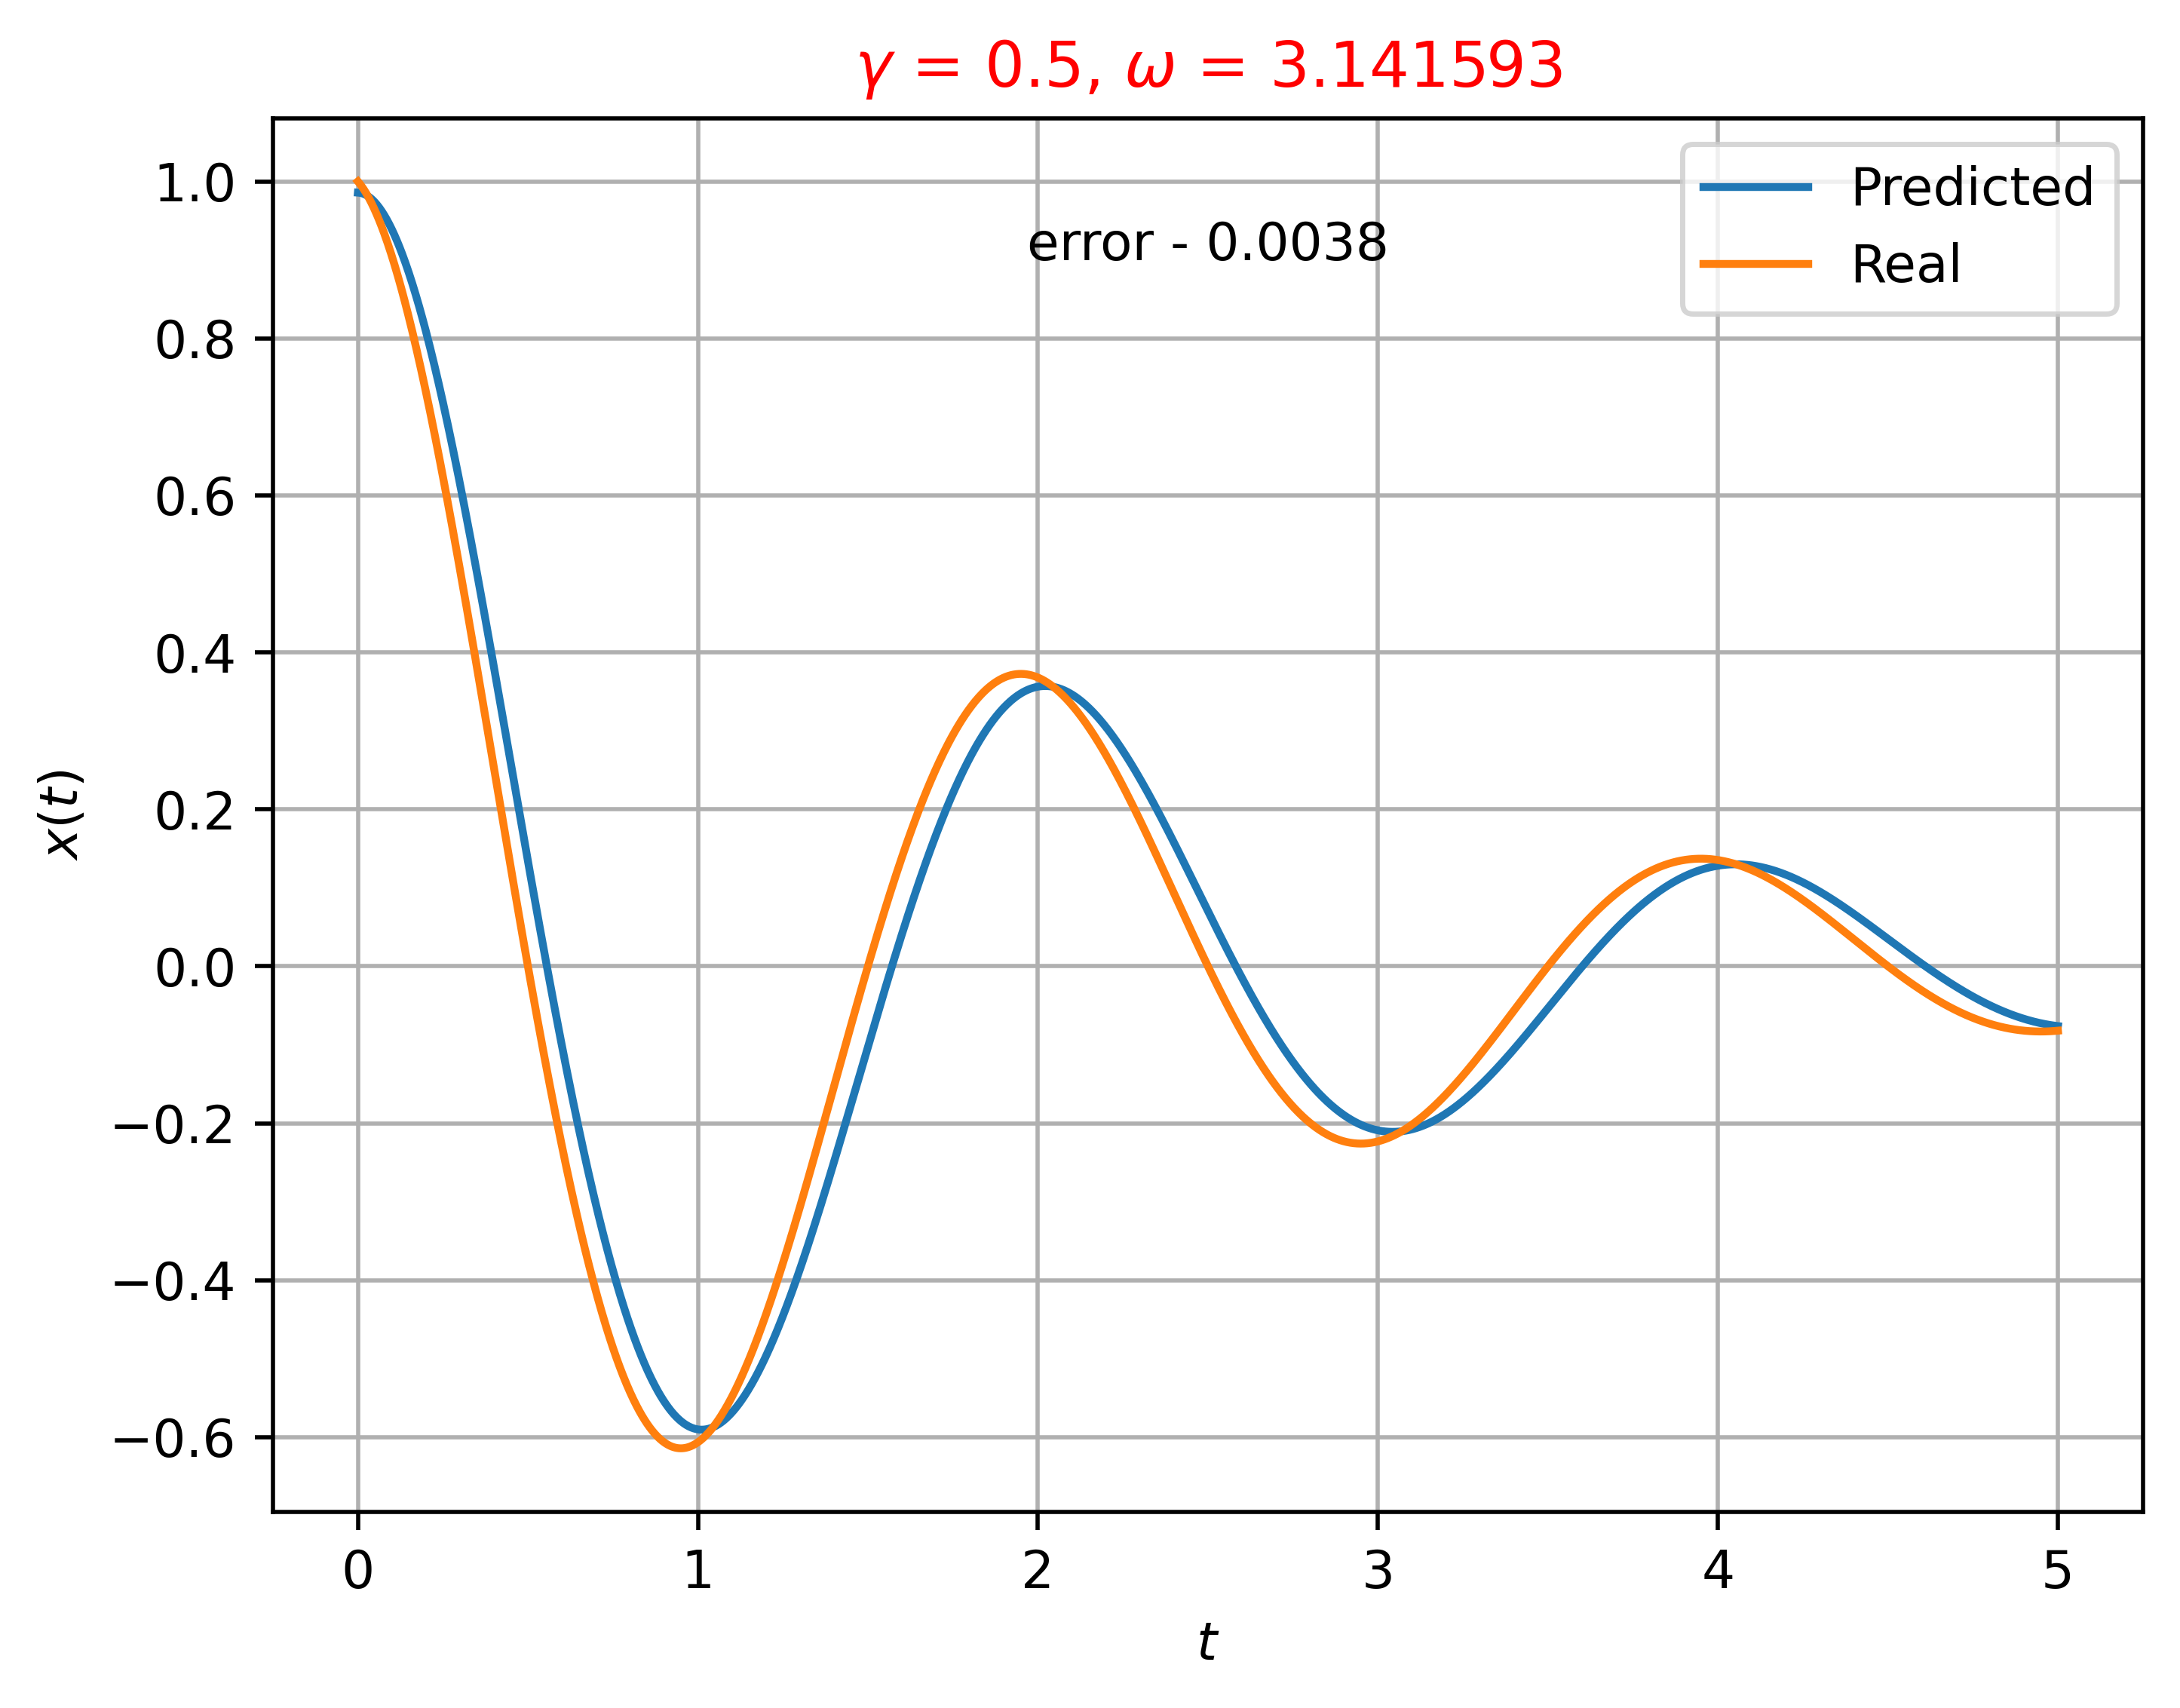

In [10]:
# plotting

plt.figure(dpi=500)
plt.ylabel(f'$x(t)$')
plt.xlabel(f'$t$')
plt.plot(t.detach().numpy(), x_test.detach().numpy(), label='Predicted')
plt.plot(t.detach().numpy(), realX(x_start, gamma, t, omega, 0), label='Real')
plt.legend()
plt.title(f'$\gamma$ = {gamma}, $\omega$ = {omega:3f}', color='r')
plt.grid(True)
plt.text(t_max/2, 0.9*x_start, f'error - {error:.4f}', ha='center')
plt.show()


This performance is...*fine*. Clearly there is some aspect of the frequency the model refuses to learn properly. But remember - there is almost no training data here, at all! We only gave the model 1 point for boundary conditions. Usually, in higher dimensions, the boundary conditions would be across some domain of values, giving the model more to data to work with.

Let's try giving the model a few more points with an exactly known training value.

In [19]:
from random import sample

trainPts = 50
idx = torch.Tensor(sample(range(N_total), trainPts))
new_t_train = t[idx]

TypeError: new() received an invalid combination of arguments - got (list, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


At this point we have not yet computed the velocities for all points in the domain. So let's redefine the training data function to compute both position and velocity.

In [ ]:
def realX_V(amp, gamma, t, omega, delta):
    assert type(t) == torch.Tensor
    x = (amp*torch.exp(-gamma*t))*torch.cos(omega*t - delta)
    v = autograd.grad(x, t, torch.ones(t.shape[0], 1), create_graph=True)[0]
    return x, v

In [ ]:
realX, realV = realX_V(x_start, gamma, t, omega, 0)
new_x_train = realX[idx]
new_v_train = realV[idx]

In [ ]:
# visualise
plt.figure(dpi=500)
plt.plot(t, realX, label='$X$ - All')
plt.plot(t, realV, label='$V$ - All')
plt.scatter(new_t_train, new_x_train, label='$X$ - train set')
plt.scatter(new_t_train, new_v_train, label='$V$ - train set')
plt.legend()
plt.show()

NameError: name 'plt' is not defined